In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


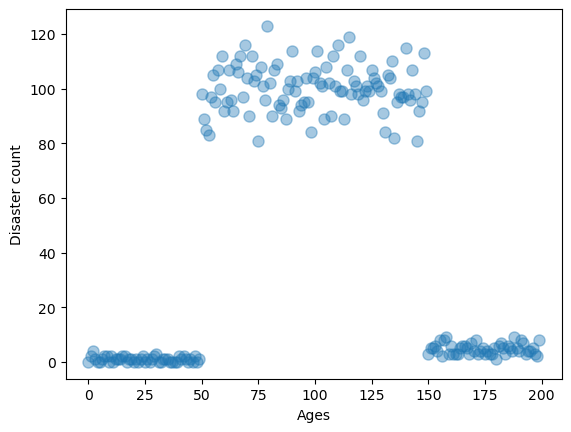

In [3]:
# fmt: off
from numpy import random 

data1 = random.poisson(lam = 1, size = 50)
data2 = random.poisson(lam = 100, size = 100)
data3 = random.poisson(lam = 5, size = 50)

zircons_data = np.concatenate([data1,data2,data3])
ages_nominal = np.arange(0, 200)

plt.plot(ages_nominal, zircons_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Ages");

In [4]:
#k=2 , n=200
#读取用来查的表switchPointList

switchPointList = []

import csv

f = open('2_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList.append(temp)
print(type(np.array(switchPointList[1])))

<class 'numpy.ndarray'>


In [5]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:] = rates[2]
    return rate

In [6]:
with pm.Model() as zircons_model:
    
    k = 2
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    

    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    
    index = pm.DiscreteUniform("index", lower = 0, upper = len(switchPointList))
    rates = pm.Exponential("rates",1.0,shape = k+1)
    rate = rate_(index, rates)
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


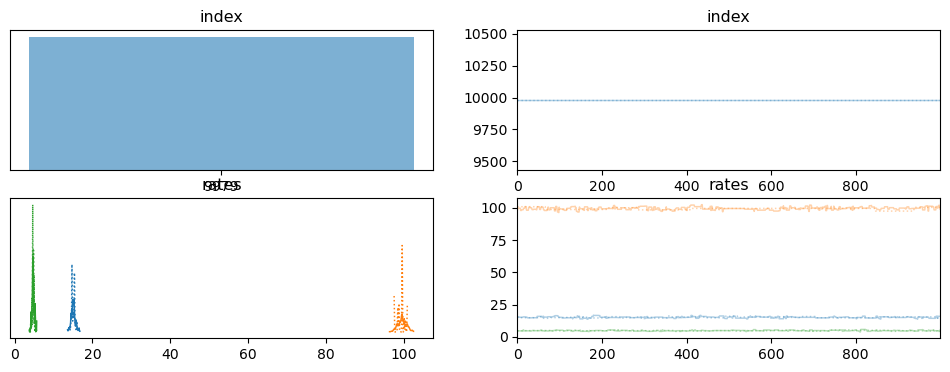

In [7]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [8]:
print(switchPointList[9979])

[59, 150]


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


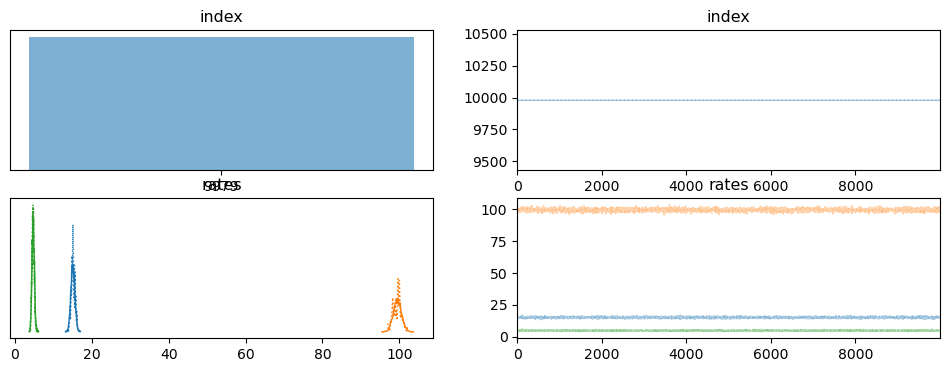

In [9]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune =10000, draws = 10000, step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [10]:
az.summary(tr)

E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,9979.000,0.000,9979.000,9979.000,0.000,0.000,20000.0,20000.0,NaN
rates[0],15.110,0.502,14.236,16.102,0.016,0.012,937.0,1143.0,1.01
rates[1],99.480,1.081,97.537,101.517,0.058,0.041,353.0,600.0,1.00
rates[2],4.736,0.303,4.182,5.286,0.007,0.005,1869.0,1608.0,1.00


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


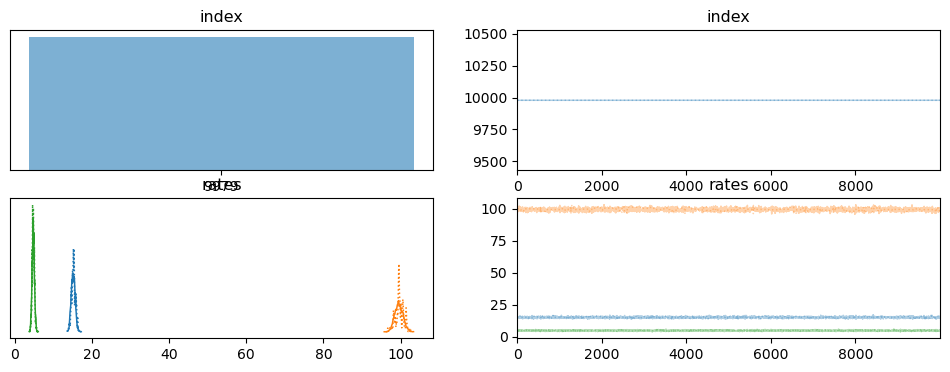

In [11]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    start = {"rates": (2.0 , 2.0 , 2.0)}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune =10000, draws = 10000, step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [12]:
az.summary(tr)

E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,9979.000,0.000,9979.000,9979.000,0.000,0.000,20000.0,20000.0,NaN
rates[0],15.160,0.502,14.205,16.061,0.015,0.011,1149.0,770.0,1.01
rates[1],99.619,1.093,97.711,101.746,0.062,0.044,325.0,391.0,1.01
rates[2],4.759,0.299,4.236,5.364,0.007,0.005,1871.0,2072.0,1.00


In [13]:
print(switchPointList[9979])
print(type(switchPointList))


[59, 150]
<class 'list'>


In [14]:
tr =pm.distributions.transforms

Order = tr.Ordered()

In [15]:
with pm.Model() as model:
    
    k =2
    
    rates = pm.Exponential("rates",1.0,shape = k + 1)
    
    switchpoints = pm.Uniform("switchpoints", lower = 0, upper = max(ages_nominal) , shape = k, transform = Order,  initval=np.linspace(1,199,k))
    #x = pm.Uniform("x", 0.0, 1.0, shape = n, transform = chain_tran)
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(switchpoints[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    tr50000 = pm.sample(draws =5000,tune = 5000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rates, switchpoints]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 2658 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rates[0],0.928,0.139,0.682,1.199,0.006,0.004,485.0,864.0,1.01
rates[1],99.220,0.962,97.401,100.967,0.031,0.022,980.0,2016.0,1.00
rates[2],4.753,0.298,4.217,5.334,0.011,0.008,746.0,1193.0,1.00
switchpoints[0],49.464,0.289,49.000,49.930,0.021,0.015,197.0,867.0,1.02
switchpoints[1],149.513,0.292,149.060,149.998,0.013,0.009,558.0,2703.0,1.01


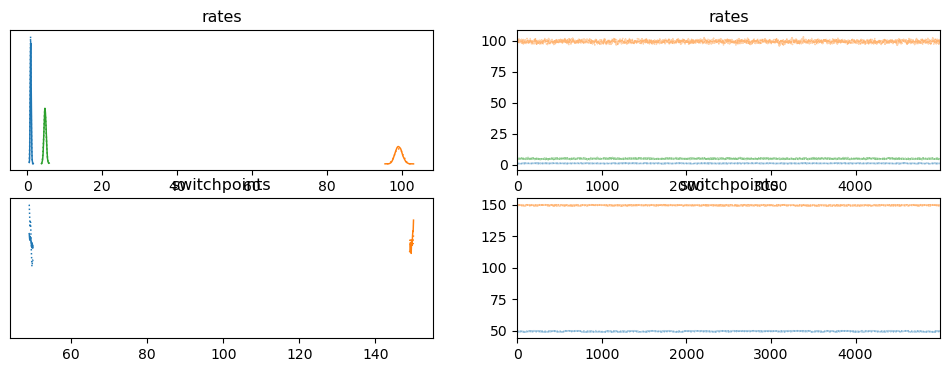

In [16]:
with model:
    az.plot_trace(tr50000)
    
pm.summary(tr50000)